# 1. Library - Parameter - Load data

In [2]:
# Import libraries
# Remove warnings
import warnings
warnings.filterwarnings("ignore")
# Basic libraries
import os
import time
import random
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm
# Visualization library
import matplotlib.pyplot   as plt
# Sklearn library
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Torch libraries
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import DataLoader
from   torch.utils.data             import Dataset

In [3]:
# Neural networks parameters
class Parameters():
    def __init__(self):
        self.description = 'DLinear model for time-series forecasting'
        # Neural network model parameters
        # Input sequence length - look-back
        self.Lag         = 100
        # Prediction sequence length
        self.Horizon     = 1
        #
        self.individual  = False
        self.enc_in      = 1
        self.kernel_size = 25
        # Training parameters
        # Number of epochs
        self.epochs        = 100
        # Batch size
        self.batch_size    = 32
        # Number of workers in DataLoader
        self.num_workers   = 0
        # Define verbose
        self.verbose       = True
        # Learning rate
        self.learning_rate = 1e-4
        # Trained model path
        # self.model_path    = 'models/DLinear.pth'
        # Data handling
        # self.filename              = '/content/bnb_processed_data.xlsx'
        # Target series name
        self.targetSeries          = 'Close'
        # Training-set percentage
        self.TrainingSetPercentage = 0.9
        # Data Log-transformation
        self.Transformation        = True
        # Scaling {'Standard'}
        self.Scaling               = 'Standard'
args = Parameters()

In [4]:
# Load data
df = pd.read_excel('/content/bnb_processed_data.xlsx' )
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1914,2024-05-27,599.825928,613.388184,599.700745,603.526428,603.526428,1691663828
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745


# 2. Data handling

## Preprocess data

In [5]:
# Datetime
df['Date'] = pd.to_datetime(df['Date'])
# Set index
df.reset_index(inplace=True)
# Keep only selected time-series Close
df = pd.DataFrame( df[ [ 'Close' ] ] )

In [6]:
# Split Training/Testing
idx = int(df.shape[0] * args.TrainingSetPercentage )
df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()
df_pred_future =df[-100:].dropna()
df_train.shape,df_test.shape,df_pred_future.shape

((1727, 1), (192, 1), (100, 1))

In [7]:
# concat append/fixing lag
df_test_lag = pd.concat([df_train.iloc[-args.Lag:], df_test])
df_test_lag.shape

(292, 1)

## Data Transformation

In [8]:
# Check if data transformation is being applied:
if (args.Transformation == True):
    # Print a message indicating data transformation is applied
    print('[INFO] Data transformation applied')

    # Compute the VALUE value by taking the ceiling of the maximum absolute value between -df.min().min() and 1.0
    VALUE = np.ceil(max(abs(-df.min().min()), 1.0))

    # Apply logarithmic transformation to df_train, df_test, and df_pred_future using the computed VALUE
    df_train = np.log(df_train + VALUE)
    df_test = np.log(df_test_lag + VALUE)
    df_pred_future = np.log(df_pred_future + VALUE)

else:
    # If no data transformation is applied, print the corresponding message
    print('[INFO] No data transformation applied.')

[INFO] Data transformation applied


In [9]:
if (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        scaler = StandardScaler()

        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )
        df_pred_future[feature]  = scaler.transform( df_pred_future[ feature ].to_numpy().reshape(-1,1) )


    # Scaling of Target Series
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_pred_future[ args.targetSeries ]  = scaler.transform( df_pred_future[  args.targetSeries  ].to_numpy().reshape(-1,1) )

[INFO] Scaling: Standard


## Create Training/Testing data

In [10]:
def create_dataset(df = None, Lag = 1, Horizon = 1, targetSeries = None, overlap = 1):

    if (targetSeries is None):
        targetSeries = df.columns[-1]

    dataX, dataY, dataDate = [], [], []

    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        dataX.append( df.to_numpy()[i:(i+Lag)] )
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        dataDate.append( df.index[i + Lag : i + Lag + Horizon].tolist() )

    return ( np.array(dataX), np.array(dataY), np.array(dataDate) )

In [11]:
trainX, trainY, trainDate = create_dataset(df           = df_train,
                                   Lag          = 100,
                                   Horizon      = 24,
                                   targetSeries = 'Close',
                                   overlap      = 1,)


testX,  testY, testDate  = create_dataset(df           = df_test,
                                          Lag          = 100,
                                          Horizon      = 1,
                                          targetSeries = 'Close',
                                          overlap      = 1,)

print('Training data shape:   ', trainX.shape, trainY.shape)
print('Testing data shape:    ', testX.shape,  testY.shape)

100%|██████████| 192/192 [00:00<00:00, 21222.99it/s]

Training data shape:    (1604, 100, 1) (1604, 24)
Testing data shape:     (192, 100, 1) (192, 1)


In [12]:
# Reshaping - Add a new dimension to the trainY/testY array at axis -1 ((N, 1) -> (N,1,1))
trainY = np.expand_dims(trainY, axis = -1)
testY  = np.expand_dims(testY,  axis = -1)
trainY.shape,testY.shape

((1604, 24, 1), (192, 1, 1))

In [13]:
# Define a class Data that inherits from Dataset
class Data(Dataset):
    def __init__(self, X, Y):
        # Initialize attributes X and Y
        self.X = X
        self.Y = Y

    def __len__(self):
        # Return the length of the dataset, based on the number of elements in Y
        return len(self.Y)

    def __getitem__(self, idx):
        # Return a data sample at index idx, including X[idx] and Y[idx]
        return self.X[idx], self.Y[idx]

# Create Data objects for training and testing datasets
train_ds = Data(trainX, trainY)
test_ds  = Data(testX, testY)

# Prepare DataLoaders for training and testing datasets
train_dl = DataLoader(train_ds, batch_size=args.batch_size, num_workers=args.num_workers)
test_dl  = DataLoader(test_ds,  batch_size=args.batch_size, num_workers=args.num_workers)

print('[INFO] Data loaders were created')

[INFO] Data loaders were created


# 3. Model DLinear

In [14]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.Lag  = configs.Lag
        self.Horizon = configs.Horizon

        # Decompsition Kernel Size
        kernel_size       = configs.kernel_size
        self.decompsition = series_decomp(kernel_size)
        self.individual   = configs.individual
        self.channels     = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend    = nn.ModuleList()
            self.Linear_Decoder  = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Trend.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Decoder.append(nn.Linear(self.Lag,self.Horizon))
        else:
            self.Linear_Seasonal = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Trend = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Decoder = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
            self.Linear_Trend.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.Horizon],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.Horizon],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

## Setup model

In [15]:
# Check and set up GPU for TensorFlow and PyTorch
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            device = torch.device( 'cuda:0' )

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)

            device = torch.device( 'cpu' )
except: # If no GPU is found, set device for PyTorch to CPU
    device = torch.device( 'cpu' )
    print('[INFO] Not GPU found - CPU selected')

[INFO] Not GPU found - CPU selected


In [16]:
# Initialize a neural network model
model = Model(args)
# Move the model to the specified device (GPU or CPU)
model.to(device)
# Print the model summary or information
print(model)

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=100, out_features=1, bias=True)
  (Linear_Trend): Linear(in_features=100, out_features=1, bias=True)
  (Linear_Decoder): Linear(in_features=100, out_features=1, bias=True)
)


## Training process

In [17]:
# Specify loss function
criterion = nn.MSELoss()
# Specify loss function
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr     = args.learning_rate)

In [18]:
Loss = {
         'Train': []
       }
# Set number at how many iteration the training process (results) will be provided
batch_show = (train_dl.dataset.__len__() // args. batch_size // 5)
# Main loop - Training process
for epoch in range(1, args.epochs+1):

    # Start timer
    start = time.time()

    # Monitor training loss
    #
    train_loss = 0.0
    valid_loss  = 0.0
    # Train the model #
    batch_idx = 0
    for data, target in train_dl:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (device.type == 'cpu'):
            data   = torch.tensor(data,   dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
        else:
            data   = torch.tensor(data,   dtype=torch.float32).cuda()
            target = torch.tensor(target, dtype=torch.float32).cuda()
        outputs = model( data )
        # Calculate the loss
        loss = criterion(outputs, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()*data.size(0)
        # Increase batch_idx
        batch_idx  += 1
        # Info
        if (args.verbose == True and batch_idx % batch_show == 0):
            print('> Epoch: {} [{:5.0f}/{} ({:.0f}%)]'.format(epoch, batch_idx * len(data), len(train_dl.dataset), 100. * batch_idx / len(train_dl)))
    # Print avg training statistics
    train_loss = train_loss / train_dl.dataset.X.shape[0]
    # Store train/val loss
    Loss['Train'] += [ train_loss ]
    # Stop timer
    stop  = time.time()
    # Show training results
    print('\n[INFO] Train Loss: {:.6f} \tTime: {:.2f}secs'.format(train_loss, stop-start), end=' ')

> Epoch: 1 [  320/1604 (20%)]
> Epoch: 1 [  640/1604 (39%)]
> Epoch: 1 [  960/1604 (59%)]
> Epoch: 1 [ 1280/1604 (78%)]
> Epoch: 1 [ 1600/1604 (98%)]

[INFO] Train Loss: 0.112332 	Time: 0.34secs > Epoch: 2 [  320/1604 (20%)]
> Epoch: 2 [  640/1604 (39%)]
> Epoch: 2 [  960/1604 (59%)]
> Epoch: 2 [ 1280/1604 (78%)]
> Epoch: 2 [ 1600/1604 (98%)]

[INFO] Train Loss: 0.105595 	Time: 0.21secs > Epoch: 3 [  320/1604 (20%)]
> Epoch: 3 [  640/1604 (39%)]
> Epoch: 3 [  960/1604 (59%)]
> Epoch: 3 [ 1280/1604 (78%)]
> Epoch: 3 [ 1600/1604 (98%)]

[INFO] Train Loss: 0.099811 	Time: 0.26secs > Epoch: 4 [  320/1604 (20%)]
> Epoch: 4 [  640/1604 (39%)]
> Epoch: 4 [  960/1604 (59%)]
> Epoch: 4 [ 1280/1604 (78%)]
> Epoch: 4 [ 1600/1604 (98%)]

[INFO] Train Loss: 0.094247 	Time: 0.34secs > Epoch: 5 [  320/1604 (20%)]
> Epoch: 5 [  640/1604 (39%)]
> Epoch: 5 [  960/1604 (59%)]
> Epoch: 5 [ 1280/1604 (78%)]
> Epoch: 5 [ 1600/1604 (98%)]

[INFO] Train Loss: 0.089031 	Time: 0.52secs > Epoch: 6 [  320/1604 (2

### Get predictions

In [19]:
# Predict on test data
pred = None
with torch.no_grad():
    for data, target in tqdm( test_dl ):

        data   = torch.tensor(data,   dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        if (pred is None):
            pred = model( data ).numpy()
        else:
            pred = np.concatenate([pred, model( data ).numpy()])
testY.shape,pred.shape

100%|██████████| 6/6 [00:00<00:00, 404.67it/s]


((192, 1, 1), (192, 1, 1))

In [20]:
# Reshaping - Remove the dimension of size 1 at the last axis of testY (ex: (N, 1,1) -> (N,1))
testY = testY.squeeze(-1)
pred  = pred.squeeze(-1)
testY.shape,pred.shape

((192, 1), (192, 1))

### Apply inverse scaling/transformation

In [21]:
# Apply inverse scaling process
for i in range(args.Horizon):
    # Inverse scaling for each column of testY and pred
    # Convert each column of testY and pred back to the original values before scaling
    testY[:, i] = scaler.inverse_transform(testY[:, i].reshape(-1, 1)).squeeze(-1)
    pred[:, i] = scaler.inverse_transform(pred[:, i].reshape(-1, 1)).squeeze(-1)

# Apply inverse transformation process
if args.Transformation == True:
    # If data was previously transformed (e.g., log transform), reverse it
    # Convert testY and pred back to their original form if they were transformed before
    testY = np.exp(testY) - VALUE
    pred = np.exp(pred) - VALUE

print('Shape of test y and pred' , testY.shape, pred.shape)

Shape of test y and pred (192, 1) (192, 1)


In [22]:
# Assign
pred_test=pred
testY_test=testY

In [23]:
# Calculate
outputs_test = np.array(pred_test)
outputs_test = outputs_test.flatten()
# Tính MAE
mae_test = np.mean(np.abs(testY_test - outputs_test))
# Tính MAPE
mape_test = np.mean(np.abs((testY_test - outputs_test) / testY_test)) * 100
# Tính RMSE
rmse_test = np.sqrt(np.mean((testY_test - outputs_test) ** 2))

print("MAE:", mae_test)
print("MAPE:", mape_test)
print("RMSE:", rmse_test)

MAE: 158.36399571763144
MAPE: 41.22282957569185
RMSE: 199.92848679428732


# 4. Forecast Next 30/60/90 Days

In [24]:
# 30/60/90 days
import torch
import numpy as np

def predict_days_dlinear(model, start_input, n_steps, predict_days):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  # Convert start_input to torch tensor
  start_input_tensor = torch.tensor(start_input, dtype=torch.float32).unsqueeze(0).to(device)

  # Initialize an array to store predicted values
  predicted_values = []

  # Predict for each day
  for day in range(predict_days):
      with torch.no_grad():
          # Predict using the model
          prediction = model(start_input_tensor)
          # Append the prediction to the list (assuming single value prediction)
          predicted_values.append(prediction[:, -1, :])
          # Update start_input_tensor for the next prediction step
          # start_input_tensor = torch.cat([start_input_tensor[:, 1:], prediction2], dim=2)
          start_input_tensor = torch.cat([start_input_tensor[:, 1:, :], prediction], dim=1)

  # Convert predicted_values to numpy array
  predicted_values = np.array(predicted_values)

  return predicted_values

# Assuming model is your trained DLinear model
start_input = np.array(df_pred_future)  # Use your data here
n_steps = 100  # Lag used during training
predicted_values_30 = predict_days_dlinear(model, start_input, n_steps, 30)
predicted_values_60 = predict_days_dlinear(model, start_input, n_steps, 60)
predicted_values_90 = predict_days_dlinear(model, start_input, n_steps, 90)
print("Predicted values for the next 30 days:", predicted_values_30)
print("Predicted values for the next 30 days:", predicted_values_60)
print("Predicted values for the next 30 days:", predicted_values_90)

Predicted values for the next 30 days: [[[1.2633204]]

 [[1.247675 ]]

 [[1.2304646]]

 [[1.2119441]]

 [[1.1919874]]

 [[1.1760939]]

 [[1.1565415]]

 [[1.1442885]]

 [[1.1324958]]

 [[1.1246477]]

 [[1.1190871]]

 [[1.1157727]]

 [[1.1206458]]

 [[1.1200923]]

 [[1.1173406]]

 [[1.1187055]]

 [[1.122441 ]]

 [[1.1208776]]

 [[1.1238353]]

 [[1.123862 ]]

 [[1.1108925]]

 [[1.1062016]]

 [[1.0941359]]

 [[1.0889132]]

 [[1.0786757]]

 [[1.0685768]]

 [[1.0633637]]

 [[1.0467706]]

 [[1.0344379]]

 [[1.0227302]]]
Predicted values for the next 30 days: [[[1.2633204 ]]

 [[1.247675  ]]

 [[1.2304646 ]]

 [[1.2119441 ]]

 [[1.1919874 ]]

 [[1.1760939 ]]

 [[1.1565415 ]]

 [[1.1442885 ]]

 [[1.1324958 ]]

 [[1.1246477 ]]

 [[1.1190871 ]]

 [[1.1157727 ]]

 [[1.1206458 ]]

 [[1.1200923 ]]

 [[1.1173406 ]]

 [[1.1187055 ]]

 [[1.122441  ]]

 [[1.1208776 ]]

 [[1.1238353 ]]

 [[1.123862  ]]

 [[1.1108925 ]]

 [[1.1062016 ]]

 [[1.0941359 ]]

 [[1.0889132 ]]

 [[1.0786757 ]]

 [[1.0685768 ]]



In [25]:
# Remove the last dimension of predicted_values if its size is 1. (Simplify the data structure)
pred_30=predicted_values_30.squeeze(-1)
pred_60=predicted_values_60.squeeze(-1)
pred_90=predicted_values_90.squeeze(-1)

In [26]:
# Apply inverse scaling
for i in range(args.Horizon):
    pred_30[:, i] = scaler.inverse_transform(pred_30[:, i].reshape(-1, 1)).squeeze(-1)
    pred_60[:, i] = scaler.inverse_transform(pred_60[:, i].reshape(-1, 1)).squeeze(-1)
    pred_90[:, i] = scaler.inverse_transform(pred_90[:, i].reshape(-1, 1)).squeeze(-1)
# Apply inverse transformation
if args.Transformation == True:
    pred_30 = np.exp(pred_30) - VALUE
    pred_60 = np.exp(pred_60) - VALUE
    pred_90 = np.exp(pred_90) - VALUE

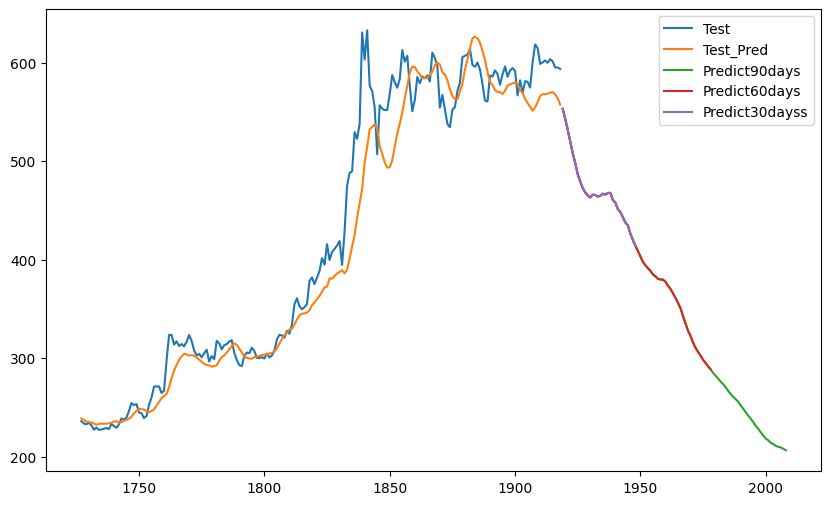

In [27]:
# Index
test_data_index = pd.RangeIndex(start=len(df_train), stop=len(df_train) + len(df_test)-100, step=1)
predict_30_days_index = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
predict_60_days_index = pd.RangeIndex(start=len(df), stop=len(df) + 60, step=1)
predict_90_days_index = pd.RangeIndex(start=len(df), stop=len(df) + 90, step=1)
# Plt
plt.figure(figsize=(10, 6))
plt.plot(test_data_index, testY_test, label='Test')
plt.plot(test_data_index, pred_test, label='Test_Pred')
plt.plot(predict_90_days_index,pred_90, label='Predict90days')
plt.plot(predict_60_days_index,pred_60, label='Predict60days')
plt.plot(predict_30_days_index,pred_30, label='Predict30dayss')
plt.legend()
plt.show()